# PSF analysis

Many objects identified by the matching procedure seem to be, at first sight, real "stars". On close examination, they appear to have a systematically narrower PSF than real stars in their vicinity. 

In this notebook, we attempt at an statistical analysis of these objects, with the goal of measuring the probability of any given detection to be a plate artifact. We use the following procedure:

- select objects from the first plate using same criteria for match finding;
- remove non-matched objects from table;
- measure the FWHM of all these objects (use subsample of brigther objects);
- measure the FWHM of all objects that weren't matched at the second plate;
- compare statistically the two FWHM samples.

This assumes that the non-matched objects have shapes that can be modelled by a PSF. The sample will have to be cleaned of obvious non-candidates such as scratches and the like. It remains to be seen how we can do that.

In [1]:
import os, io
import csv
from math import sqrt

import numpy as np

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy import stats

from astropy import units as u
from astropy.io import fits
from astropy.io.fits import Header, Card
from astropy.table import Table, join, hstack
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, ICRS
from astropy.nddata.utils import Cutout2D
from astropy.stats import SigmaClip

from photutils.background import Background2D, MedianBackground, ModeEstimatorBackground

from library import clean_bad_fits, remove_outsiders, fit_fwhm
from settings import get_parameters, fname, current_dataset

## Functions

In [2]:
def plot_from_tables(table_list):
    
    col_names = ['fwhm_fit', 'elongation', 'qfit', 'cfit']
    colors = ['blue', 'red']
    labels = ['Match', 'No match']
    sizes = [1, 10]
    
    ylims = (
        (0., 30.),      # fwhm
        (0.9, 1.55),   # elong
        (-0.2, 4.),     # qfit
        (-0.005, 0.005)     # cfit
    )

    fig = plt.figure(figsize=(10, 8))

    for subplot_index, col in enumerate(col_names):

        ax = fig.add_subplot(2, 2, subplot_index+1)
        
        for index, table in enumerate(table_list):
        
            x1 = table['flux_max']
            y1 = table[col]

            color = colors[index]
            label = labels[index]
            size  = sizes[index]
        
            ax.scatter(x1, y1, label=label, color=color, s=size)
            
            ax.set_ylim(bottom=ylims[subplot_index][0], top=ylims[subplot_index][1])
            
            ax.set_xlabel('Peak flux')
            ax.set_ylabel(col)
            ax.set_title(col + ' distribution')
            ax.legend()

        plt.grid()

    plt.tight_layout()
    plt.show()

In [3]:
par = get_parameters(current_dataset)
par

{'nproc': 8,
 'sextractor_flags': 4,
 'model_prediction': 0.8,
 'max_flux_threshold': 0.3,
 'elongation': 1.5,
 'annular_bin': 4,
 'flag_rim': 0,
 'nbrighter': 150000,
 'sampling_step': 10,
 'min_acceptable_flux': 25000,
 'min_fwhm': 5.0,
 'max_fwhm': 7.5,
 'qfit_max': 5.0,
 'cfit_max': 5.0,
 'invert_east': [False, False],
 'invert_north': [False, False],
 'table1': 'sources_9319.csv',
 'table2': 'sources_9320.csv',
 'table1_calib': 'sources_calib_9319.csv',
 'table2_calib': 'sources_calib_9320.csv',
 'table_matched': 'table_match_9319_9320.fits',
 'table_non_matched': 'table_nomatch_9319_9320.fits',
 'table_psf_nonmatched': 'table_psf_nomatch_9319_9320.fits',
 'image1': 'GS00768_x.fits',
 'image2': 'GS00769_x.fits'}

## Input data

Necessary input tables were created by script **find_mismatches**.

In [4]:
table_match = Table.read(fname(par['table_matched']), format='fits')
table_nomatch = Table.read(fname(par['table_non_matched']), format='fits')

In [5]:
print(len(table_match), len(table_nomatch))

13988 37


In [6]:
# read image

f = fits.open(fname(par['image1']))
data = f[0].data

header = fits.getheader(fname(par['image1']))
wcs_image = WCS(header)

# photographic images are reversed ("negative"). Make result a float array for convenience.
data = 65535. - data

# subtract background
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(data, 2000, filter_size=101, sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

data = data - bkg.background

Set MJD-AVG to 35810.852292 from DATE-AVG.
Set MJD-END to 35810.857488 from DATE-END'. [astropy.wcs.wcs]


## Measure FWHM of matched objects

These objects, collected in **table_match**, have their FWHM measured here. This sample is then the basis from which we can compare FWHM of non-matched objects.

Because of the sheer size of the **table_match** sample, we create a subsample made by sorting the table in peak flux of each object, and only picking every Nth object starting from the brightest. This ensures a more or less even coverage in peak flux, and should ignore the faint end of the distribution, where more problems are expected. Remember that we just want to pick up unquestionably good star images. These script parameters should be found by trial and error for each data set.

Peak flux is better than magnitude, because magnitude depends on both peak flux and FWHM. The sample of non-matched objects may have systematically different FWHM values from the basis sample, so we want to make comparisons based on a parameter that is independentg of FWHM. 

In [7]:
# build subsample with brighter objects. Select the N-th brightest.

nbrighter = par['nbrighter']
sampling_step = par['sampling_step']

table_match.sort('flux_max', reverse=True)

table_match = table_match[0:nbrighter:sampling_step]

print(len(table_match), "  -  Peak flux range:", table_match['flux_max'][0], table_match['flux_max'][-1])

1399   -  Peak flux range: 55619.434 16704.02


**table_match** now contains an appropriate sample of good star images. 

In [8]:
table_match

source_id,process_id_1,scan_id_1,plate_id_1,archive_id_1,solution_num,annular_bin_1,dist_center_1,dist_edge_1,sextractor_flags_1,model_prediction_1,ra_icrs,dec_icrs,ra_error,dec_error,gal_lon,gal_lat,ecl_lon,ecl_lat,x_sphere,y_sphere,z_sphere,healpix256,healpix1024,nn_dist,zenith_angle,airmass,natmag,natmag_error,bpmag,bpmag_error,rpmag,rpmag_error,natmag_plate,natmag_correction,natmag_residual,phot_range_flags,phot_calib_flags,color_term,cat_natmag,match_radius,gaiaedr3_id,gaiaedr3_gmag,gaiaedr3_bp_rp,gaiaedr3_dist,gaiaedr3_neighbors,timestamp_insert_1,timestamp_update_1,pos,process_id_2,scan_id_2,plate_id_2,archive_id_2,source_num,x_source,y_source,a_source,b_source,theta_source,erra_source,errb_source,errtheta_source,elongation,x_peak,y_peak,flag_usepsf,x_image,y_image,erra_image,errb_image,errtheta_image,x_psf,y_psf,erra_psf,errb_psf,errtheta_psf,mag_auto,magerr_auto,flux_auto,fluxerr_auto,mag_iso,magerr_iso,flux_iso,fluxerr_iso,flux_max,flux_radius,isoarea,sqrt_isoarea,background,sextractor_flags_2,dist_center_2,dist_edge_2,annular_bin_2,flag_rim,flag_negradius,flag_clean,model_prediction_2,timestamp_insert_2,timestamp_update_2
int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,bytes10,bytes10,bytes10,bytes10,bytes10,bytes10,float64,bytes15,bytes15,int64,int64,bytes9,bytes10,float64,bytes19,bytes4,bytes10,bytes12,int64,bytes29,bytes29,bytes42,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,bytes4,bytes4,bytes4,bytes4,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,int64,int64,float64,bytes29,bytes29
40349380033122,34938,12209,9319,102,1,2,1900.6083,3466.0205,3,1.0,358.50810493540484,56.4894187381668,0.0968428,0.0834128,115.02997529420131,-5.499045117139616,29.989830064346584,50.420938604400355,0.5519038271921535,-0.014373985982019359,0.8337838773073286,226809,3628944,19.575798,18.299034,1.0530821,7.392293,0.5141622,7.0723066,0.514197,5.2727766,0.514197,7.9415765,-0.5492836,NULL,0,0,1.1778167,NULL,0.6390662,1995033410178846464,NULL,1.79953,0.4799884,1,2022-06-13 20:53:25.680547+00,2022-06-13 20:53:25.680547+00,"(6.25714682620815 , 0.985926349518791)",34938,12209,9319,102,33122,7417.5664,3465.9261531102934,11.083314,9.348683,-3.0670424,0.021227973,0.016268114,-1.5207378,1.1855481,7419,3465,0,7417.5664,3466.0205,0.021227973,0.016268114,-1.5207378,NULL,NULL,NULL,NULL,NULL,5.6886992,0.0023868948,53029836.0,116553.07,5.8900485,0.001495076,44053520.0,60647.66,55619.434,13.557053,1788,42.284748,318.07867,3,1900.6083,3466.0205,2,0,0,1,1.0,2022-06-13 05:05:13.513042+00,2022-06-13 05:05:13.513042+00
40349380059556,34938,12209,9319,102,0,2,1816.6727,2461.4634,2,1.0,359.4467463531907,57.139758117285844,0.0968428,0.0834128,115.67392155014336,-4.9740120197354445,31.25995954411791,50.60709315015901,0.5425664030730383,-0.005239237052955553,0.8399965765712908,226814,3629037,24.09757,17.74815,1.0498041,NULL,NULL,NULL,NULL,NULL,NULL,0.0,NULL,NULL,0,0,NULL,NULL,0.0,NULL,NULL,NULL,NULL,1,2022-06-13 20:53:25.680547+00,2022-06-13 20:53:25.680547+00,"(6.2735292094441 , 0.997276912939794)",34938,12209,9319,102,59556,5392.852,6047.004135761867,13.139461,12.099442,1.3183923,0.02325956,0.020669358,3.4920561,1.085956,5395,6047,0,5392.852,6046.5366,0.02325956,0.020669358,3.4920561,NULL,NULL,NULL,NULL,NULL,5.4059205,0.0021978067,68806870.0,139248.81,5.6129336,0.0014221605,56862584.0,74463.836,53636.508,16.387722,2704,52.0,2093.2651,2,1816.6727,2461.4634,2,0,0,1,1.0,2022-06-13 05:05:13.513042+00,2022-06-13 05:05:13.513042+00
40349380045584,34938,12209,9319,102,1,1,910.2925,3841.913,3,0.9994317,358.92965456438236,56.79250450535438,0.0968428,0.0834128,115.32366490210931,-5.253899429216662,30.5716950609034,50.51

In [9]:
# some applause tables contain source coordinates that fall outside the corresponding image's
# footprint. We remove these from the table, before calling the FWHM fit function. That prevents
# it from raising NoOverlapErrors

table_match = remove_outsiders(data, wcs_image, table_match)

In [10]:
print(len(table_match))

1399


In [11]:
# measure fwhms on matched table

x_pos = list(table_match['x_source'])
y_pos = list(table_match['y_source'])

xypos = list(zip(x_pos, y_pos))

fwhm_values, phot_match = fit_fwhm(data, xypos=xypos, fwhm=8., fit_shape=31)

In [12]:
print(len(table_match), len(phot_match.results))

1399 1399


In [13]:
# hstack the FWHM fit results with the main analysis table.

table_1 = hstack([table_match, phot_match.results])

Remove non-realistic FWHM values. These come probably from non-convergent solutions in the FWHM fitting procedure. 

In [14]:
table_1 = clean_bad_fits(table_1, par)

In [15]:
table_1

source_id,process_id_1,scan_id_1,plate_id_1,archive_id_1,solution_num,annular_bin_1,dist_center_1,dist_edge_1,sextractor_flags_1,model_prediction_1,ra_icrs,dec_icrs,ra_error,dec_error,gal_lon,gal_lat,ecl_lon,ecl_lat,x_sphere,y_sphere,z_sphere,healpix256,healpix1024,nn_dist,zenith_angle,airmass,natmag,natmag_error,bpmag,bpmag_error,rpmag,rpmag_error,natmag_plate,natmag_correction,natmag_residual,phot_range_flags,phot_calib_flags,color_term,cat_natmag,match_radius,gaiaedr3_id,gaiaedr3_gmag,gaiaedr3_bp_rp,gaiaedr3_dist,gaiaedr3_neighbors,timestamp_insert_1,timestamp_update_1,pos,process_id_2,scan_id_2,plate_id_2,archive_id_2,source_num,x_source,y_source,a_source,b_source,theta_source,erra_source,errb_source,errtheta_source,elongation,x_peak,y_peak,flag_usepsf,x_image,y_image,erra_image,errb_image,errtheta_image,x_psf,y_psf,erra_psf,errb_psf,errtheta_psf,mag_auto,magerr_auto,flux_auto,fluxerr_auto,mag_iso,magerr_iso,flux_iso,fluxerr_iso,flux_max,flux_radius,isoarea,sqrt_isoarea,background,sextractor_flags_2,dist_center_2,dist_edge_2,annular_bin_2,flag_rim,flag_negradius,flag_clean,model_prediction_2,timestamp_insert_2,timestamp_update_2,id,group_id,group_size,local_bkg,x_init,y_init,flux_init,fwhm_init,x_fit,y_fit,flux_fit,fwhm_fit,x_err,y_err,flux_err,fwhm_err,npixfit,qfit,cfit,flags
int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,bytes10,bytes10,bytes10,bytes10,bytes10,bytes10,float64,bytes15,bytes15,int64,int64,bytes9,bytes10,float64,bytes19,bytes4,bytes10,bytes12,int64,bytes29,bytes29,bytes42,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,bytes4,bytes4,bytes4,bytes4,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,int64,int64,float64,bytes29,bytes29,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64
40349380033122,34938,12209,9319,102,1,2,1900.6083,3466.0205,3,1.0,358.50810493540484,56.4894187381668,0.0968428,0.0834128,115.02997529420131,-5.499045117139616,29.989830064346584,50.420938604400355,0.5519038271921535,-0.014373985982019359,0.8337838773073286,226809,3628944,19.575798,18.299034,1.0530821,7.392293,0.5141622,7.0723066,0.514197,5.2727766,0.514197,7.9415765,-0.5492836,NULL,0,0,1.1778167,NULL,0.6390662,1995033410178846464,NULL,1.79953,0.4799884,1,2022-06-13 20:53:25.680547+00,2022-06-13 20:53:25.680547+00,"(6.25714682620815 , 0.985926349518791)",34938,12209,9319,102,33122,7417.5664,3465.9261531102934,11.083314,9.348683,-3.0670424,0.021227973,0.016268114,-1.5207378,1.1855481,7419,3465,0,7417.5664,3466.0205,0.021227973,0.016268114,-1.5207378,NULL,NULL,NULL,NULL,NULL,5.6886992,0.0023868948,53029836.0,116553.07,5.8900485,0.001495076,44053520.0,60647.66,55619.434,13.557053,1788,42.284748,318.07867,3,1900.6083,3466.0205,2,0,0,1,1.0,2022-06-13 05:05:13.513042+00,2022-06-13 05:05:13.513042+00,1,1,1,0.0,7417.5664,3465.9261531102934,31045086.0,8.0,7416.726133421057,3464.9137062219056,42445916.212850824,24.582102877776677,0.07711612105755754,0.07691232435655908,402413.6967921846,0.16987149364301757,961,0.09966639170264073,-0.00021767492681022088,0
40349380059556,34938,12209,9319,102,0,2,1816.6727,2461.4634,2,1.0,359.4467463531907,57.139758117285844,0.0968428,0.0834128,115.67392155014336,-4.9740120197354445,31.25995954411791,50.60709315015901,0.5425664030730383,-0.005239237052955553,0.8399965765712908,226814,3629037,24.09757,17.74815,1.0498041,NULL,NULL,NULL,NULL,NULL,NULL,0.0,NULL,NULL,0,0,NULL,NULL,0.0,NULL,NULL,NULL,NULL,1,2022-06-13 20:53:25.680547+00,2022-06-13 20:53:25.680547+00,"(6.2735292094441 , 0.997276912939794)",34938,12209,9319,102,59556,5392.852,6047.004135761867,13.139461,12

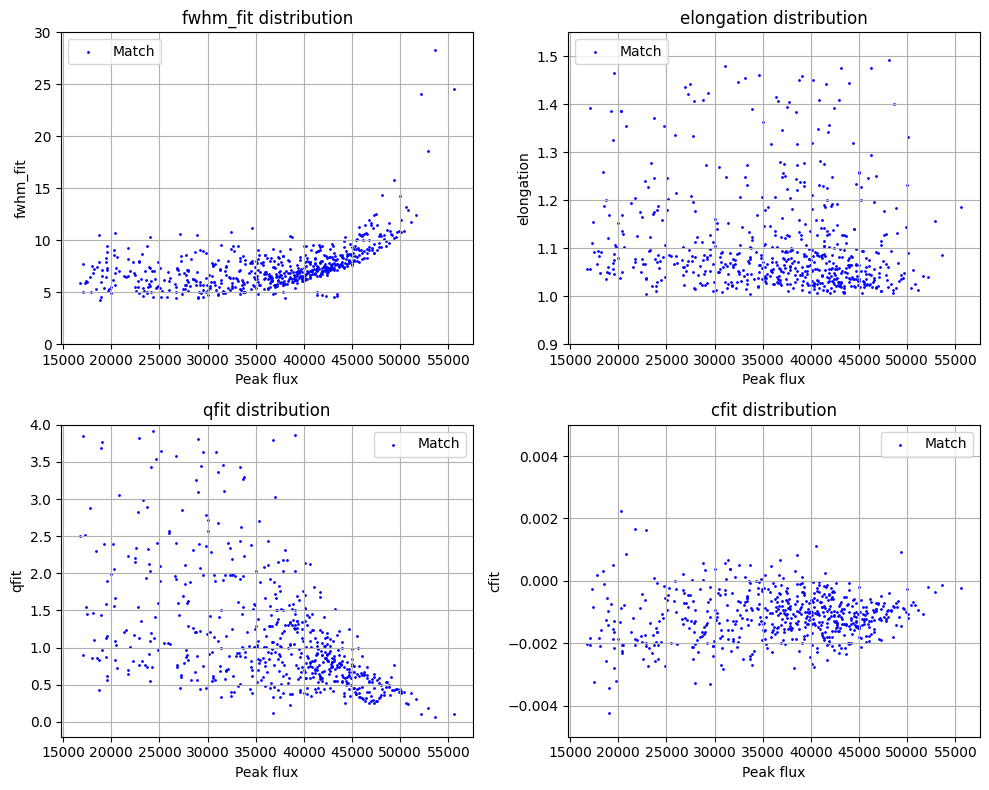

In [16]:
plot_from_tables([table_1])

## Measure FWHM of non-matched objects

In [17]:
# handle NoOverlapErrors
table_nomatch = remove_outsiders(data, wcs_image, table_nomatch)

print(len(table_nomatch))

37


In [18]:
# measure fwhms

x_pos = list(table_nomatch['x_source'])
y_pos = list(table_nomatch['y_source'])

xypos = list(zip(x_pos, y_pos))

fwhm_values_nomatch, phot_nomatch = fit_fwhm(data, xypos=xypos, fwhm=6., fit_shape=31)

In [19]:
# hstack the FWHM fit results with the non-matched table.

table_nomatch_1 = hstack([table_nomatch, phot_nomatch.results])

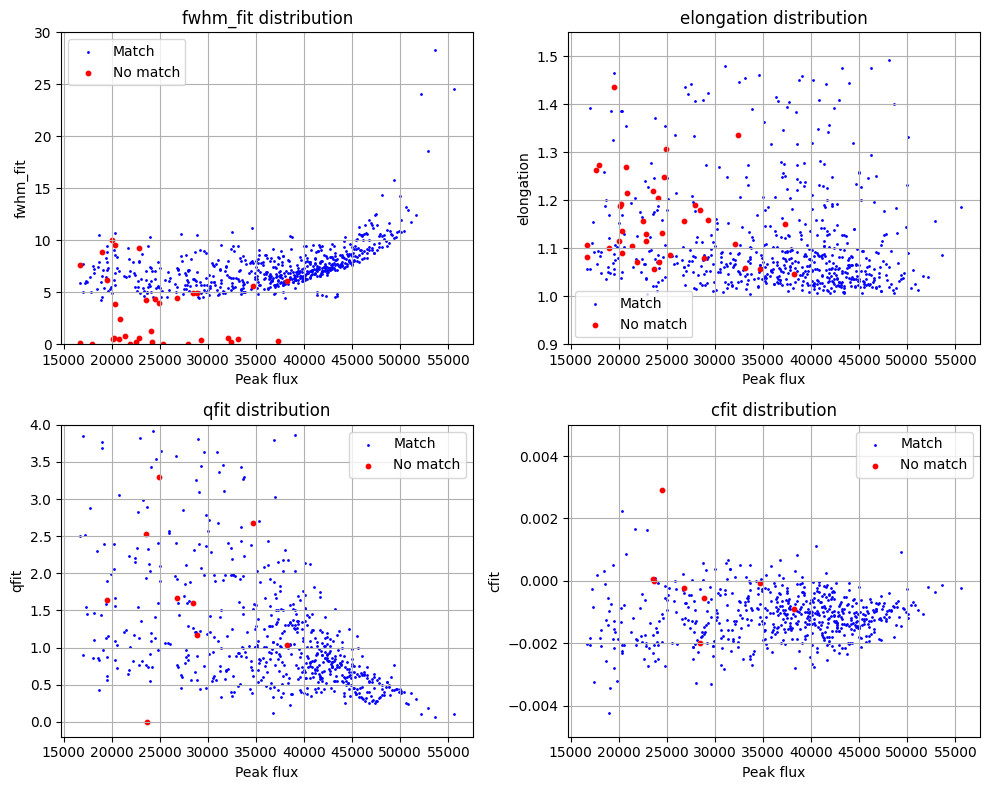

In [20]:
plot_from_tables([table_1, table_nomatch_1])

### Remove suspect data from non-matched set

Non-matched points can be the result of a too faint, or otherwise non-detecable, source on the second plate. These fail to be detected by Sextractor, but can be spotted visually in the plots. 

In order to minimize the number of images to be visualized (script **display_nomatches**), we retain only the points with higher odds of being a real object imaged thru the telescope: sufficiently bright, and with PSFs that are indistinguishable from stars, based on their measured properties.

In [21]:
# segregate data points within the desired ranges of parameters

mask = table_nomatch_1['flux_max'] > par['min_acceptable_flux']
t1 = table_nomatch_1[mask]
mask = t1['fwhm_fit'] < par['max_fwhm']
t1 = t1[mask]
mask = t1['fwhm_fit'] > par['min_fwhm']
t1 = t1[mask]

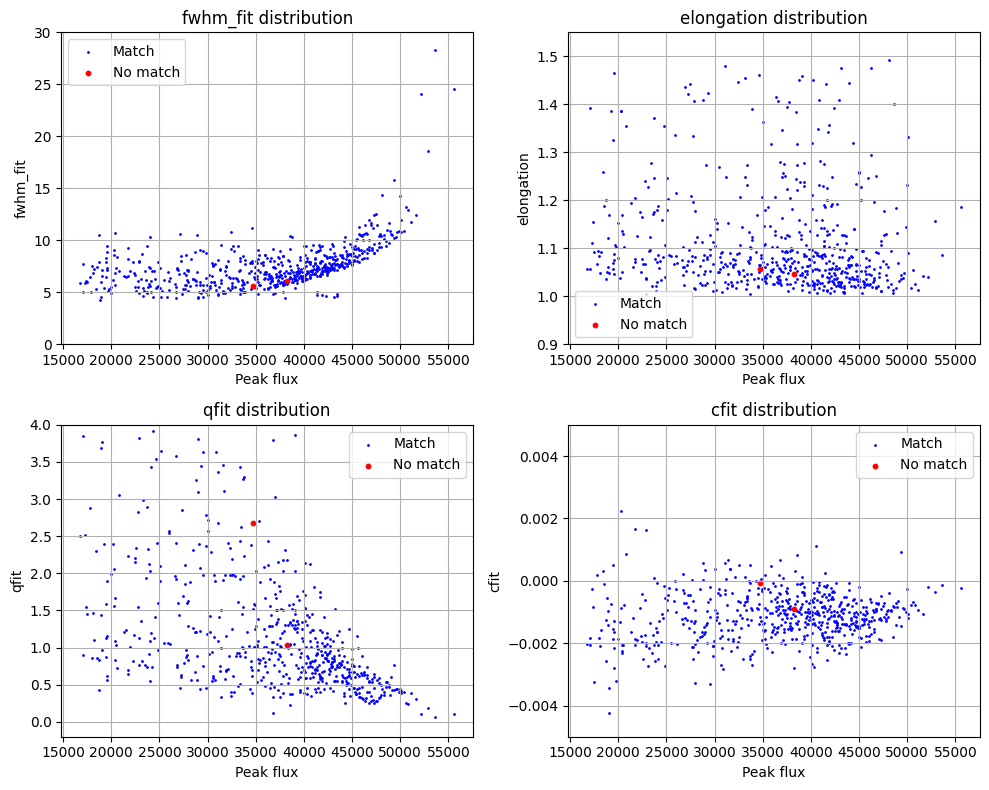

In [22]:
plot_from_tables([table_1, t1])

In [23]:
# write those selected points to file so they can be picked up by the visualization script

t1.write(fname(par['table_psf_nonmatched']), overwrite=True)

## Notes

Here is the documentation on the *qfit* and *cfit* fit quality parameters produced by the Gaussian fitting library.

- ***qfit***: a quality-of-fit metric defined as the sum of the absolute value of the fit residuals divided by the fit flux. qfit is zero for sources that are perfectly fit by the PSF model.

- ***cfit***: a quality-of-fit metric defined as the fit residual (data - model) in the initial central pixel value divided by the fit flux. NaN values indicate that the central pixel was masked. Large positive values indicate sources that are sharper than the PSF model (e.g., cosmic ray, hot pixel, etc.). Large negative values indicate sources that are broader than the PSF model